# **MIT 6.S965 Fall 2022 Lab 4: Deployment on MCU**


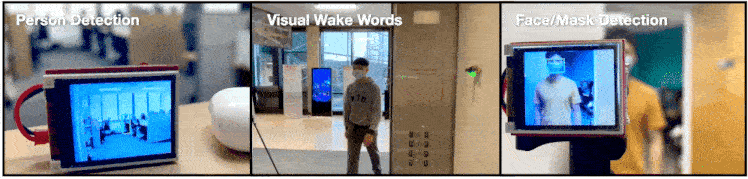

Microcontrollers (MCU) are low-cost, low-power hardware. They are widely deployed and have wide applications.

MCUNet is a system-algorithm co-design framework for tiny deep learning on microcontrollers. It consists of TinyNAS and TinyEngine. They are co-designed to fit the tight memory budgets.

With system-algorithm co-design, we can significantly improve the deep learning performance on the same tiny memory budget.

In this lab, you will:
*   Learn how to visualize deep learning models.
*   Deploy a VWW model on a MCU (STM32F746G-DISCO discovery board).
*   Observe on-device latency and memory footprint improvement achieved by different optimization techniques.

Please fill out this feedback [form](https://docs.google.com/forms/d/e/1FAIpQLSdBcyvx14isN1GrCr2Xw1iMXSeN2ftT7djBSTh-GVkLm5plrQ/viewform?usp=sf_link) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

# Setup

We will first install a few packages that will be used in this tutorial:

In [ ]:
# Install mcunet for pretrained models
!pip install git+https://github.com/mit-han-lab/mcunet
# Download TinyEngine library for deployment
!wget -O tinyengine.zip "https://hanlab.mit.edu/files/course/labs/tinyengine.zip"
!unzip -o tinyengine.zip
!mv tinyengine/code_generator .

We will then import a few libraries:

In [ ]:
from mcunet.model_zoo import build_model, download_tflite
from code_generator.CodegenUtilTFlite import GenerateSourceFilesFromTFlite
from google.colab import files

# Download a pretrained VWW (Visual Wake Word) model
Let's download the `mcunet-5fps-vww` pretrained model from mcuent. This model will later be deployed in the MCU. You can also download the model from [here](https://hanlab.mit.edu/files/course/labs/lab4/mcunet-5fps_vww.tflite).

Visual Wake Words is a common microcontroller vision use-case for identifying whether a person is present in the image or not, and provides a realistic benchmark for tiny vision models.

Please refer to the [model zoo](https://github.com/mit-han-lab/mcunet#model-list) of mcunet for more detailed statistics of the model.



In [ ]:
model, image_size, description = build_model(net_id="mcunet-5fps-vww", pretrained=True) 
tflite_path = download_tflite(net_id="mcunet-5fps-vww")
files.download(tflite_path)

# Model visualization


Let's first have a quick overview and visualize this model at a block-wise level.

In [ ]:
from tinyengine.arch_visualization_helper import visualize_model
visualize_model(model)

To further investigate the vww model, we can use Netron, a cross-platform tool, to visualizing layer-wise information.

1.   Visualize the downloaded model through [Netron](https://github.com/lutzroeder/netron). You can either install it locally or use their [browser version](https://netron.app/).
2.   In Netron, click `Open Model...` to visualize the model downloaded to your PC.

After opening the model with Netron, you can explore the model in great detail. For example, you can see the information of properties, attributes, inputs, and outputs of a convolution layer by clicking the node as below.

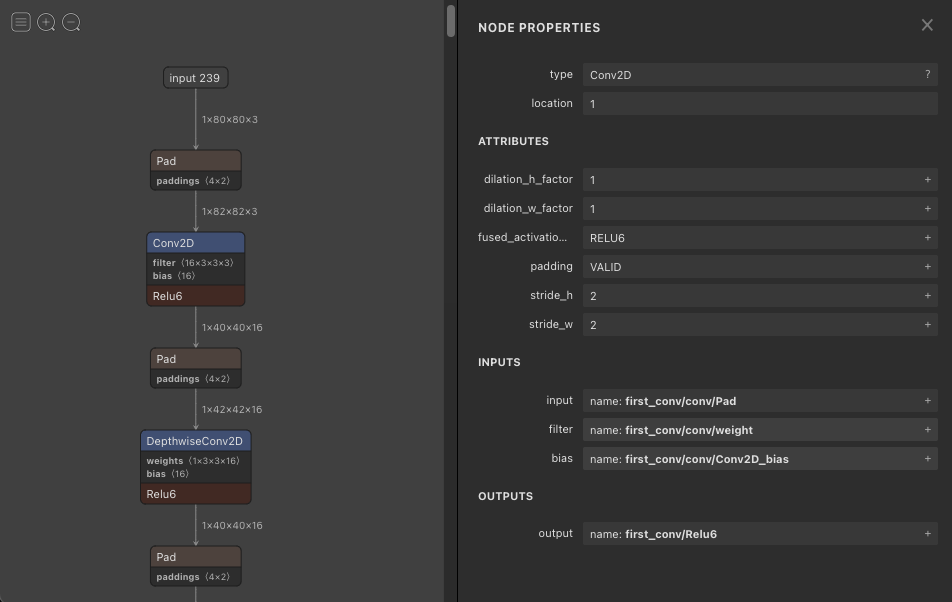




## Question 1: Neural Architecture (10pt)

How many depthwise and pointwise convolution layers (1x1) are there in the `mcunet-5fps-vww` model? Please refer to the visualization result from Netron.

**Your Answer:**
1. Number of depthwise conlution layers:
2. Number of pointwise convolution layers:

# Deployment with TinyEngine



Introduction of TinyEngine, a memory-efficient inference library. TinyEngine adapts the memory scheduling according to the overall network topology rather than layer-wise optimization, reducing the memory usage and accelerating the inference. It outperforms existing inference libraries such as TF-Lite Micro from Google and CMSIS-NN from ARM.

TinyEngine adopts the folloing optimization techniques to acclerate infernece and minmize memory footprint.

*   [**Loop reordering**](https://xilinx.github.io/Vitis_Accel_Examples/2019.2/html/loop_reorder.html): A loop transformation technique that attempts to optimize a program's execution speed by reordering/interchanging the sequence of loops.
*   [**Loop unrolling**](https://en.wikipedia.org/wiki/Loop_unrolling): A loop transformation technique that attempts to optimize a program's execution speed at the expense of its binary size, which is an approach known as space-time tradeoff.
*   [**SIMD (Single instruction, multiple data) instructions**](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data): A computing method that enables processing of multiple data with a single instruction.
*   [**Image to Column (Im2col) convolution**](https://iq.opengenus.org/im2col/): An implementation technique of computing convolution operation using general matrix multiplication (GEMM) operations.
*   [**HWC to CHW weight format transformation**](https://oneapi-src.github.io/oneDNN/dev_guide_understanding_memory_formats.html): A weight format transformation technique that increases cache hit ratio for in-place depth-wise convolution.
*   [**In-place depth-wise convolution**](https://mcunet.mit.edu/#mcunetv1): A unique data placement technique for depth-wise convolution that overwrites input data by intermediate/output data to reduce peak SRAM memory.

Please refer to the TinyEngine [GitHub](https://github.com/mit-han-lab/tinyengine) and the MCUNet [website](https://mcunet.mit.edu/) for more information.



Now we will generate C source files for the model using TinyEngine for on-device deployment. You can change the `optimization_config` to turn on/off optimization techniques.

TinyEngine derives the memory schedules for each activation tensor. It will output the number of activation tensors and memory footprint as a figure for visualization.




In [ ]:
############### YOUR CODE STARTS HERE ###############
optimization_config = {
    "loop_reordering": True, # Enable loop reordering optimization
    "im2col": True, # Enable im2col convolution
    "hwc2chw_weight": True, # Enable HWC -> CHW format transformation for weights
    "loop_unrolling": True, # Enable loop unrolling optimization
    "simd": True, # Enable SIMD programming
    "inplace_depthwise": True, # Enable inplace depthwise convolution
}
############### YOUR CODE ENDS HERE ###############
tensor_lfe_cycle_path = "./lifecycle.png"
peakmem = GenerateSourceFilesFromTFlite(
    tflite_path,
    life_cycle_path=tensor_lfe_cycle_path,
    custom_optimization_config=optimization_config,
)
print(f"Peak memory: {peakmem} bytes")

## Question 2: Memory Reduction of In-place Depthwise Convolution (20pt)

Please change the `optimization_config` to enable/disable in-place depthwise convolution and evaluate the memory reduction from in-place depthwise convolution.

### Question 2.1: Peak Memory (10pt)

What are peak memory and number of activation tensors before and after enabling in-place depthwise update?

**Your Answer:**

Before enabling in-place depthwise update, the peak memory is:

After enabling in-place depthwise update, the peak memory is:

Before enabling in-place depthwise update, the number of activation tensors is:

After enabling in-place depthwise update, the number of activation tensors is:

### Question 2.2: Memory Bottleneck (10pt)

Which tensor leads to the memory bottleneck before and after enabling in-place depthwise update? Please specify its tensor id.

**Your Answer:**

Before enabling in-place depthwise update, the memory bottleneck tensor is:

After enabling in-place depthwise update, the memory bottleneck tensor is:

##Let's compress the generated source files and download `codegen.zip` to your PC.

In [ ]:
!zip -r codegen.zip codegen
files.download("codegen.zip")

Now, let's try to learn how to deploy the neural network model onto your own STM32F746G-DISCO discovery board to enable person detection with Tiny Inference Engine. For the detailed instructions, please see [Lab 4 instruction document](https://hanlab.mit.edu/files/course/labs/MIT_Efficient_AI_Course_Lab_4_Deployment_on_MCU.pdf).

Overall, there are six primary steps you need to do:
1.   Download the codebase of Tiny Inference Engine and also STM32CubeIDE, an C/C++ development platform with peripheral configuration, code generation, code compilation, and debug features for STM32 microcontrollers and microprocessors.
2.   Setup STM32CubeIDE for compilation and run.
3.   Setup your STM32F746G-DISCO discovery board to connect the Arducam to the board and also establish the USB connection with the board.
4.   Run the demo. The LCD screen on your STM32F746G-DISCO discovery board should display person detection results (person/no person) and frames per second (FPS), as shown in the figure below.
5.   Turn on each optimization technique in `optimization_config` iteratively and generate different C source files.
6.   Observe the change of inference speed (frames per second) with different optimization technique settings.

Enjoy the demo!



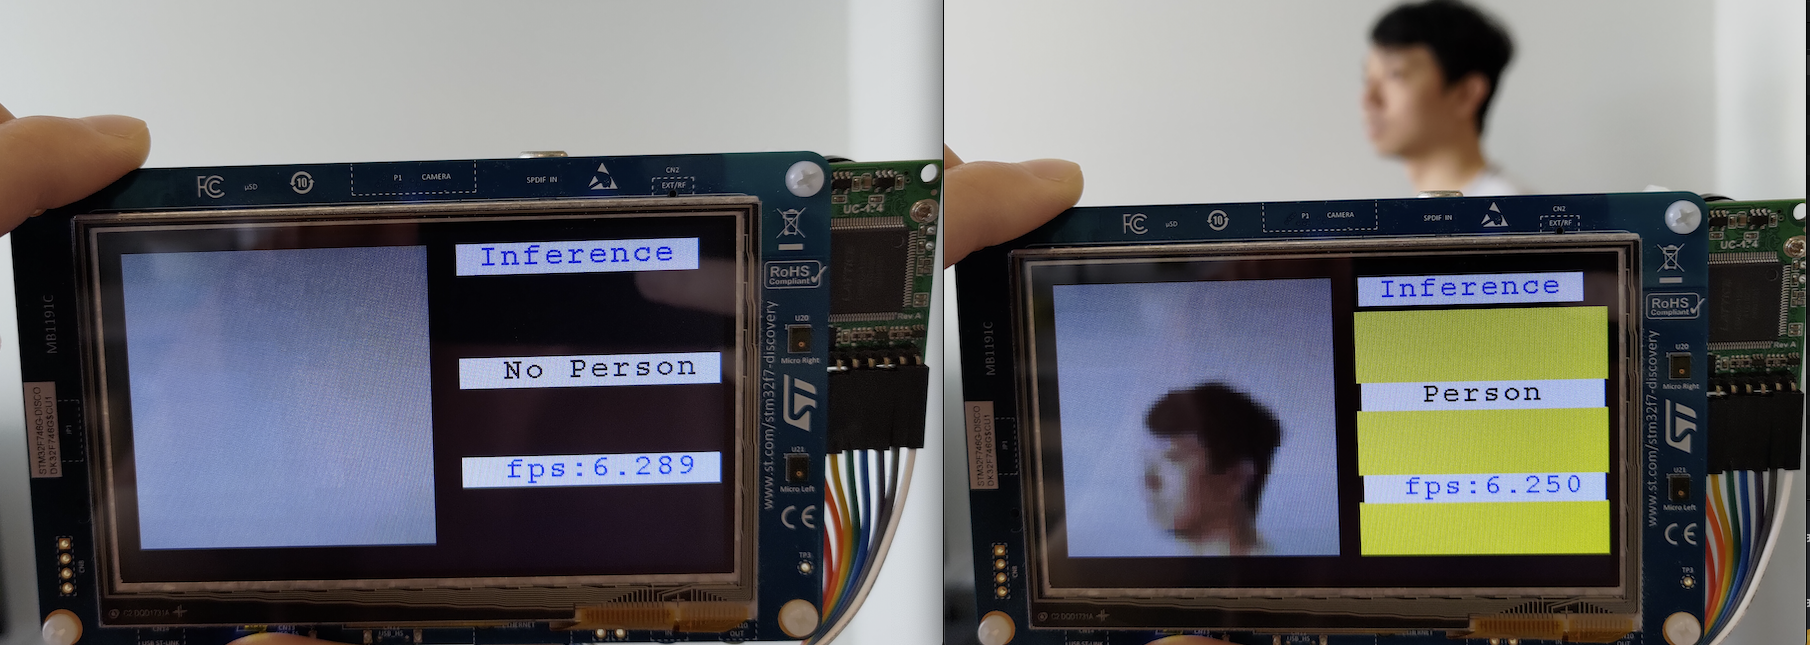

## Question 3: Engine optimization techniques (35pt)


### Question 3.1:  How many FPS without enabling any optimization technique? (5pt)

**Your Answer:**

### Question 3.2:  How many FPS after enabling loop reordering? (5pt)

**Your Answer:**

### Question 3.3:  How many FPS after enabling loop reordering and im2col convolution? (5pt)

**Your Answer:**

### Question 3.4:  How many FPS after enabling loop reordering, im2col convolution and HWC to CHW weight transformation? (5pt)

**Your Answer:**

### Question 3.5:  How many FPS after enabling loop reordering, im2col convolution, HWC to CHW weight transformation and loop unrolling? (5pt)

**Your Answer:**

### Question 3.6:  How many FPS after enabling loop reordering, im2col convolution, HWC to CHW weight transformation, loop unrolling and SIMD programming? (5pt)

**Your Answer:**

### Question 3.7:  How many FPS after enabling all of our optimization techniques (i.e., loop reordering, im2col convolution, HWC to CHW weight transformation, loop unrolling, SIMD programming and in-place depthwise convolution)? (5pt)

**Your Answer:**

##Let's trace the codebase and learn how these optimization techniques are realized in Tiny Inference Engine.
The general convolution and pointwise convolution operators are located in: `{your_path}/Src/TinyEngine/src/kernels`

The depthwise convolution operators are located in: `{your_path}/Src/TinyEngine/codegen/Source`.

Each file name indicates what convolution it is. 
For exmaple, `convolve_1x1_s8.c` indicates it is a pointwise (1x1 kernel size) convolution operator, and `depthwise_kernel3x3_stride1_inplace_CHW.c` indicates it is a depthwise convolution operator with 3x3 kernel size and stride 1.

Take `TinyEngine/src/kernels/fp_requantize_op/convolve_1x1_s8_fpreq.c` as an exmaple. In this file, you will find that we use multiple "[macros](https://www.programiz.com/c-programming/c-preprocessor-macros)" to switch on/off different optimization techniques. For instance, it will execute Lines 36-61 when `loop_reordering` is set as False.

Please review the optimization techniques introduced in the slides of Lecture 10 and further trace the codebase to learn how these optimization techniques are realized and why the speed/memory footprint can be improved in Tiny Inference Engine.

In [ ]:
# The following code snippet is for demonstration and not runnable on Colab
#if (!LOOP_REORDERING) 
  /* Similar to TF-Lite Implementation */
	for (int out_y = 0; out_y < output_y; ++out_y) {
		for (int out_x = 0; out_x < output_x; ++out_x) {
			for (int out_channel = 0; out_channel < output_ch; ++out_channel) {
				int32_t sum = 0;
				for (int filter_y = 0; filter_y < DIM_KER_Y; ++filter_y) {
					for (int filter_x = 0; filter_x < DIM_KER_X; ++filter_x) {
						for (int in_channel = 0; in_channel < input_ch; ++in_channel) {
							int32_t input_val = input[Offset(input_y, input_x, input_ch, 0, out_y, out_x, in_channel)];
							int32_t filter_val = kernel[Offset(DIM_KER_Y, DIM_KER_X, input_ch, out_channel, filter_y, filter_x, in_channel)];
							sum += filter_val * (input_val + input_offset);
						}
					}
				}

				if (bias) {
					sum += bias[out_channel];
				}
				sum = (int32_t) ((float)sum * scales[out_channel]);
				sum += out_offset;
				sum = MAX(sum, out_activation_min);
				sum = MIN(sum, out_activation_max);

				output[Offset(output_y, output_x, output_ch, 0, out_y, out_x, out_channel)] = (int8_t)(sum);
			}
		}
	}

## Question 4: Please trace the codebase of Tiny Inference Engine and answer following questions. (35pt)

Hint: The source code uses `#if`, `#elif`, and `#endif` to control which portions of the source file are compiled. More detailed information can be found [here](https://docs.microsoft.com/en-us/cpp/preprocessor/hash-if-hash-elif-hash-else-and-hash-endif-directives-c-cpp?view=msvc-170).

### Question 4.1:  In [convolve_1x1_s8_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/convolve_1x1_s8_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `loop_unrolling` and `simd`? (8pt)

**Your Answer:**

### Question 4.2:  In [depthwise_kernel3x3_stride1_inplace_CHW_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/depthwise_kernel3x3_stride1_inplace_CHW_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `im2col`, `hwc2chw_weight`, `loop_unrolling` and `inplace_depthwise`? (9pt)

**Your Answer:**

### Question 4.3: In [convolve_1x1_s8_ch48_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/convolve_1x1_s8_ch48_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering` and `loop_unrolling`? (9pt)


**Your Answer:**

### Question 4.4: In [depthwise_kernel7x7_stride2_inplace_CHW_fpreq.c](https://hanlab.mit.edu/files/course/labs/lab4/depthwise_kernel7x7_stride2_inplace_CHW_fpreq.c), which part of the code (Lines) will be executed when we only enable `loop_reordering`, `im2col` and `hwc2chw_weight`? (9pt)


**Your Answer:**

##Reference: Person detection demo (This part is optional)

You can also deploy a person detection demo on it. You can donwload and model and compiled binary from [here](https://hanlab.mit.edu/files/course/labs/Detection_Lab4.zip).